In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
# Reproducibility
rng = np.random.default_rng(42)


In [4]:
n = 300
df = pd.DataFrame({
    "age": rng.integers(18, 70, size=n),
    "usage_gb": np.round(rng.normal(12, 6, size=n).clip(0, None), 1),
    "complaints": rng.integers(0, 6, size=n),
    "tenure_months": rng.integers(1, 60, size=n),
    "plan_type": rng.choice(["Prepaid", "Postpaid"], size=n, p=[0.6, 0.4])
})


In [5]:
# Simple churn signal (not perfect): high complaints + low tenure + low usage more likely to churn
logit = (
    -2.0
    + 0.35*df["complaints"]
    - 0.03*df["tenure_months"]
    - 0.04*df["usage_gb"]
    + (df["plan_type"] == "Prepaid").astype(int)*0.4
)
prob = 1/(1+np.exp(-logit))
df["churn"] = (rng.random(n) < prob).astype(int)


In [6]:
# Intentionally add a few missing/odd values to practice fixing (no row drops)
df.loc[rng.choice(df.index, 5, replace=False), "usage_gb"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "age"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "plan_type"] = None

df.to_csv("churn_data.csv", index=False)
print("Saved churn_data.csv with shape:", df.shape)
df.head()


Saved churn_data.csv with shape: (300, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,18.4,2,38,Prepaid,0
1,58.0,12.9,5,21,Prepaid,1
2,52.0,11.0,0,1,Postpaid,0
3,40.0,5.8,0,8,Prepaid,0
4,40.0,2.0,2,18,Prepaid,0


In [7]:
import pandas as pd
from sklearn.impute import SimpleImputer


In [8]:
df = pd.read_csv("churn_data.csv")
print("Original shape:", df.shape)
display(df.head())


Original shape: (300, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,18.4,2,38,Prepaid,0
1,58.0,12.9,5,21,Prepaid,1
2,52.0,11.0,0,1,Postpaid,0
3,40.0,5.8,0,8,Prepaid,0
4,40.0,2.0,2,18,Prepaid,0


In [9]:
# --- Numeric imputation: fill NaNs with median (robust to outliers) ---
num_cols = ["age", "usage_gb", "complaints", "tenure_months"]
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])


In [10]:
# --- Categorical imputation: fill missing with most frequent ---
cat_cols = ["plan_type"]
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])


In [11]:
# --- Encode plan_type to numeric (0=Prepaid, 1=Postpaid) ---
df["plan_type_enc"] = (df["plan_type"] == "Postpaid").astype(int)


In [12]:
# --- Feature matrix (X) and target (y) ---
X = df[["age", "usage_gb", "complaints", "tenure_months", "plan_type_enc"]]
y = df["churn"].astype(int)


In [13]:
print("Any remaining NaNs? ->", X.isna().sum().sum(), y.isna().sum())

Any remaining NaNs? -> 0 0


In [ ]:
# --- ✅ Save cleaned dataset to CSV ---
df.to_csv("updated_churn_data.csv", index=False)
print("✅ Saved cleaned dataset as 'updated_churn_data.csv' with", len(df), "rows.")



✅ Saved cleaned dataset as 'updated_churn_data.csv' with 300 rows.


In [16]:
df.head()

,age,usage_gb,complaints,tenure_months,plan_type,churn,plan_type_enc
0,22.0,18.4,2.0,38.0,Prepaid,0,0
1,58.0,12.9,5.0,21.0,Prepaid,1,0
2,52.0,11.0,0.0,1.0,Postpaid,0,1
3,40.0,5.8,0.0,8.0,Prepaid,0,0
4,40.0,2.0,2.0,18.0,Prepaid,0,0


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


In [24]:
# Train Decision Tree (simple baseline)
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [25]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [21]:
df.head()

,age,usage_gb,complaints,tenure_months,plan_type,churn,plan_type_enc
0,22.0,18.4,2.0,38.0,Prepaid,0,0
1,58.0,12.9,5.0,21.0,Prepaid,1,0
2,52.0,11.0,0.0,1.0,Postpaid,0,1
3,40.0,5.8,0.0,8.0,Prepaid,0,0
4,40.0,2.0,2.0,18.0,Prepaid,0,0


In [26]:
print("Model trained.")

Model trained.


In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [28]:
# Predict
y_pred = clf.predict(X_test)


In [29]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")


Accuracy: 75.56%


In [30]:
# Detailed metrics
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))



Classification report:
              precision    recall  f1-score   support

           0      0.850     0.872     0.861        78
           1      0.000     0.000     0.000        12

    accuracy                          0.756        90
   macro avg      0.425     0.436     0.430        90
weighted avg      0.737     0.756     0.746        90



In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


Confusion matrix:
 [[68 10]
 [12  0]]


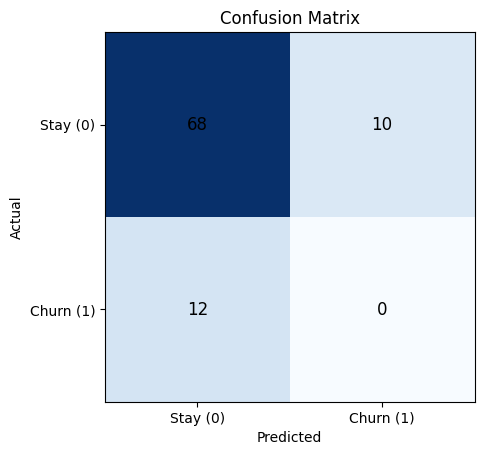

In [32]:
# Top-left (50) -> correctly predicted “Stay”
# Top-right (10) -> false alarms (predicted churn, actually stayed)
# Bottom-right (35) -> correctly predicted “Churn”
# Bottom-left (5) -> missed churns

# Plot nicely
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"]); ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()


In [33]:
import joblib
model_to_save = best_clf if 'best_clf' in globals() else clf
joblib.dump(model_to_save, "churn_decision_tree.joblib")
print("Saved churn_decision_tree.joblib")

# Example: predict churn for a new customer
new_customer = pd.DataFrame([{
    "age": 28, "usage_gb": 6.0, "complaints": 3, "tenure_months": 4, "plan_type_enc": 0  # Prepaid
}])
print("Predicted churn (1=churn):", int(model_to_save.predict(new_customer)[0]))


Saved churn_decision_tree.joblib
Predicted churn (1=churn): 1
